In [12]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

In [13]:
SEED = 42 
np.random.seed(SEED)
torch.manual_seed(SEED)

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataloader for the supervised case

In [15]:
# Transforms to range -1 to 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
full_trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
num_train = len(full_trainset)
num_valid = int(0.1 * num_train)
num_train -= num_valid

trainset, validset = random_split(full_trainset, [num_train, num_valid])

# Create the DataLoader for training and validation sets
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# Download and load the test dataset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


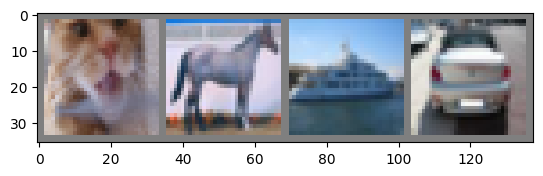

cat   horse ship  car  


In [16]:

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Dataloader for self-supervised case

In [17]:
s = 0.5

# Transforms to range -1 to 1
standard_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

simCLR_transform = transforms.Compose(
    [
        standard_transform,
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomResizedCrop(32, (0.8, 1.0)),
        transforms.Compose(
            [
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            0.8 * s,
                            0.8 * s,
                            0.8 * s,
                            0.2 * s,
                        )
                    ],
                    p=0.8,
                ),
                transforms.RandomGrayscale(p=0.2),
            ]
        ),
    ]
)

batch_size = 128

trainset_simclr = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=simCLR_transform
)
trainloader_simclr = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset_simclr = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=standard_transform
)
testloader_simclr = DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


## Neural net for classification

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Training for classification

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
num_epochs = 2
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.179
[1,  4000] loss: 1.885
[1,  6000] loss: 1.712
[1,  8000] loss: 1.604
[1, 10000] loss: 1.530
[2,  2000] loss: 1.420
[2,  4000] loss: 1.442
[2,  6000] loss: 1.366
[2,  8000] loss: 1.344
[2, 10000] loss: 1.319
Finished Training


In [21]:
# Save the model
model_path = './models/cifar_net.pth'
if not os.path.exists("models"): 
  os.makedirs("models")
torch.save(net.state_dict(), model_path)

In [22]:
# Calculate test score
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %
